In [1]:
import importlib

import ase.io as aio
from ase.units import Bohr
import numpy as np
import glob

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import bt_tools as bt
importlib.reload(bt)

from matplotlib import pyplot as plt

def ref_scatter(ref):
    return(np.linspace(np.amin(ref), np.amax(ref), 3))

In [2]:
importlib.reload(bt)

def comp_dist2(var, alpha, beta, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = (-beta*(Z1**(7/3)+Z2**(7/3))+alpha+b_prime*Z1*Z2)
    dist = a/d+b
    return(comp*dist)

def comp_gamma_dist2(var, alpha, beta, gamma, b_prime, a, b):
    Z1, Z2, d = var.T
    comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2
    dist = a/d+b
    return(comp*dist)

comp_gamma_dist2_flexible_zeff_lat = None

def comp_gamma_dist2_flexible_zeff(*args):
    globals()['comp_gamma_dist2_flexible_zeff_lat'] = args[1:]
    var = args[0]
    alpha, beta, gamma, b_prime, a, b = args[1:7]
    Zeffs = args[7:]
    lookup = [6,7,8,9,14,15,16,17,32,33,34,35]
    
    Z1, Z2, d = var.T
    Z1e = np.array([Zeffs[lookup.index(int(_))] for _ in Z1])
    Z2e = np.array([Zeffs[lookup.index(int(_))] for _ in Z2])
    comp = -beta**2*(Z1e**(gamma**2)+Z2e**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e
    dist = a/d+b
    
    return(comp*dist)

def comp_gamma_flexible_zeff(*args):
    globals()['comp_gamma_dist2_flexible_zeff_lat'] = args[1:]
    var = args[0]
    alpha, beta, gamma, b_prime = args[1:5]
    Zeffs = args[5:]
    lookup = [6,7,8,9,14,15,16,17,32,33,34,35]
    
    Z1, Z2, d = var.T
    Z1e = np.array([Zeffs[lookup.index(int(_))] for _ in Z1])
    Z2e = np.array([Zeffs[lookup.index(int(_))] for _ in Z2])
    comp = -beta**2*(Z1e**(gamma**2)+Z2e**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e
    
    return(comp)

In [3]:
weighted_core = lambda Ne, Zs, Zp: 2*Zs/Ne + (Ne-2)/Ne*Zp

zs2 = np.array([3.217, 3.847, 4.492, 5.128])
zp2 = np.array([3.136, 3.834, 4.453, 5.100])

zs3 = np.array([4.903, 	5.642, 	6.367, 	7.068])
zp3 = np.array([4.285, 4.886, 5.482, 6.116])

zs4 = np.array([8.044, 	8.944, 	9.758, 	10.553])
zp4 = np.array([6.780, 7.449, 8.287, 9.028])

zs = [zs2, zs3, zs4]
zp = [zp2, zp3, zp4]
ne = [4, 5, 6, 7]
z_eff = []
for rs, rp in zip(zs, zp):
    zr = []
    for s, p, n in zip(rs, rp, ne):
        zr.append(weighted_core(n, s, p))
    z_eff.append(zr)

In [4]:
def key2(x):
    pattern_list = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key3(x):
    pattern_list = ['SiSi', 'SiP','SiS','SiCl','PP','PS','PCl','SS','SCl','ClCl',]
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key4(x):
    pattern_list = ['[GeH3][GeH3]', '[GeH3][AsH2]', '[GeH3][SeH]', '[GeH3]Br', '[AsH2][AsH2]', '[AsH2][SeH]', '[AsH2]Br', '[SeH][SeH]', '[SeH]Br', 'BrBr']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)

dist_exact2 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/diatomics_single/*_opt.xyz', key2)
dist_exact3 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/diatomics_single/*_opt.xyz', key3)
dist_exact4 = bt.get_distances('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/diatomics_single/*_opt.xyz', key4)
dist_exact = np.concatenate((dist_exact2, dist_exact3, dist_exact4))
dist_exact = np.reshape(dist_exact, (1,30))

In [5]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

nsub = [[0,0,0,0], [0,0,0,0], [0,0,0,0]]

for e, z in zip([e2, e3, e4], z_eff):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
#             e_nuc.append(0.0)

    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc

# distances = np.array([10*[1.42] + 10*[2.12] + 10*[2.36]])
distances = dist_exact

distances /= Bohr

energies = np.concatenate((e2, e3, e4), axis = 0)

nuc_charges = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]

In [ ]:
# normal nuclear charges and exponent = 7/3
b_cd = bt.BDE_dist(energies, z_eff, distances)
b_cd.fit(comp_dist2)

plt.plot(b_cd.bde)
plt.plot(b_cd.bde_fitted)

<ipython-input-2-75db1adaf927>:11: RuntimeWarning: overflow encountered in power
  comp = -beta**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha-(b_prime**2)*Z1*Z2


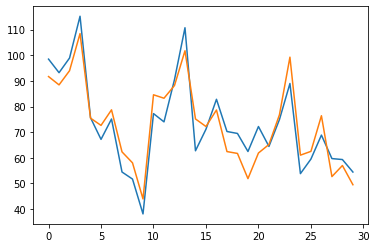

In [6]:
# normal nuclear charges and exponent = 7/3
b_cdg = bt.BDE_dist(energies, z_eff, distances)
b_cdg.fit(comp_gamma_dist2)

plt.plot(b_cdg.bde)
plt.plot(b_cdg.bde_fitted)

In [7]:
b_cdg.params[0]

array([-5.61579964e+01,  1.88968639e+00,  1.44660413e+00,  1.61740438e+01,
       -3.07969736e-02,  2.33371737e+00])

In [30]:
alpha, beta, gamma, bprime, a, b = b_cdg.params[0].copy()
p0 = np.array((alpha, abs(beta), abs(gamma), abs(bprime)))
p0 = np.concatenate((p0, np.array(z_eff).flatten()))
# p0[:]=1.0
b_cdgzo = bt.BDE_dist(energies, nuc_charges, distances)
b_cdgzo.fit(comp_gamma_flexible_zeff, p0)

<ipython-input-2-75db1adaf927>:42: RuntimeWarning: invalid value encountered in power
  comp = -beta**2*(Z1e**(gamma**2)+Z2e**(gamma**2))+alpha-(b_prime**2)*Z1e*Z2e


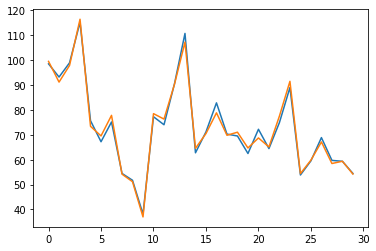

In [31]:
plt.plot(b_cdgzo.bde)
plt.plot(b_cdgzo.bde_fitted)

In [32]:
b_cdgzo.mae

1.5286333020112362

In [29]:
b_cdgzo.params[0]

array([ 3.50147954e+02, -2.18122264e-02,  8.13645211e-01,  1.33268098e+01,
        6.18693353e+00,  7.39405475e+00,  8.54530302e+00,  9.73287420e+00,
        8.79209897e+00,  9.89097407e+00,  1.09886875e+01,  1.21286952e+01,
        1.40453361e+01,  1.52310432e+01,  1.66008846e+01,  1.78885867e+01])

In [26]:
b_cdgzo.params[0]

array([-6.40742873e+03,  3.51900132e+01, -1.00704557e+00,  1.54552201e+01,
        2.07957433e-02,  1.07851632e+00,  2.07254048e+00,  3.09263830e+00,
        2.28341234e+00,  3.22779889e+00,  4.16909087e+00,  5.14526596e+00,
        6.78676113e+00,  7.80352314e+00,  8.97759673e+00,  1.00808996e+01])

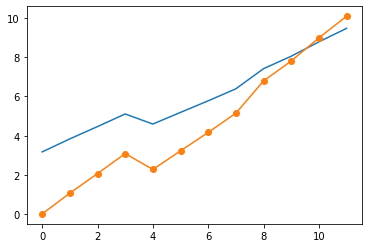

In [33]:
plt.plot(np.array(z_eff).flatten())
plt.plot(b_cdgzo.params[0][4:], '-o')

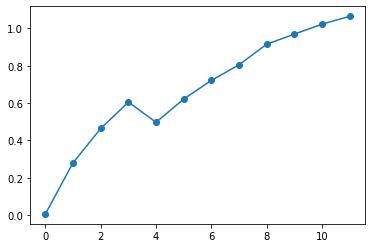

In [34]:
plt.plot(b_cdgzo.params[0][4:]/np.array(z_eff).flatten(), '-o')